In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data=pd.read_csv(("../data/transformed/transform.csv"))
data.drop(data[data['VER_issued_credits']==0].index,inplace=True)
from datetime import datetime
data.loc[pd.to_datetime(data['crediting_period_end_date'])>datetime.today(),'crediting_days']=(datetime.today()-pd.to_datetime(data[pd.to_datetime(data['crediting_period_end_date'])>datetime.today()]['crediting_period_start_date'])).dt.days
data['VER_sold_percentage_per_day']=data['VER_sold_percentage']/data['crediting_days']

In [3]:
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import make_scorer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
import sklearn.preprocessing as preprocessing

In [4]:
def TypeSplit(row,data=data):
    Type=row['type'].split(' - ')
    if Type[0]== 'Small, Low':
        Type[0]=Type[1]
    return(Type[0])

def SectorSplit(row,data=data):
    Type=row['type'].split(' - ')
    if len(Type)<2:
        Type.append(np.nan)
    if Type[0]== 'Small, Low':
        Type[1]='Electricity'
    return(Type[1])

In [5]:
data['sector']=data.apply(SectorSplit,axis=1)
data['type']=data.apply(TypeSplit,axis=1)

In [6]:
CountryEncoder=preprocessing.OneHotEncoder(sparse_output=False)
CountryEncoder.fit(data[['country_code']])
data[CountryEncoder.get_feature_names_out()]=CountryEncoder.transform(data[['country_code']])
ContinentEncoder=preprocessing.OneHotEncoder(sparse_output=False)
ContinentEncoder.fit(data[['continent_code']])
data[ContinentEncoder.get_feature_names_out()]=ContinentEncoder.transform(data[['continent_code']])
SizeEncoder=preprocessing.OneHotEncoder(sparse_output=False)
SizeEncoder.fit(data[['size']])
data[SizeEncoder.get_feature_names_out()]=SizeEncoder.transform(data[['size']])
SectorEncoder=preprocessing.OneHotEncoder(sparse_output=False)
SectorEncoder.fit(data[['sector']])
data[SectorEncoder.get_feature_names_out()]=SectorEncoder.transform(data[['sector']])
TypeEncoder=preprocessing.OneHotEncoder(sparse_output=False)
TypeEncoder.fit(data[['type']])
data[TypeEncoder.get_feature_names_out()]=TypeEncoder.transform(data[['type']])

In [7]:
world_data=pd.read_csv("../data/world_country_and_usa_states_latitude_and_longitude_values.csv")

In [8]:
def find_long(row,world_data=world_data):
    long=float(world_data.loc[world_data['country_code']==row['country_code'],'longitude'].values)
    return (long)

def find_lat(row,world_data=world_data):
    lat=float(world_data.loc[world_data['country_code']==row['country_code'],'latitude'].values)
    return (lat)

In [9]:
data.loc[data['latitude'].isna(),'latitude']=data[data['latitude'].isna()].apply(find_lat,axis=1)
data.loc[data['longitude'].isna(),'longitude']=data[data['longitude'].isna()].apply(find_long,axis=1)

In [10]:
correlation_cutoff=0.05
high_corr_vars=data.drop(['id','estimated_annual_credits','sustaincert_id','poa_project_id','poa_project_sustaincert_id','VER_issued_credits','VER_retired_credits'],axis=1).corr()[data.drop(['id','estimated_annual_credits','sustaincert_id','poa_project_id','poa_project_sustaincert_id','VER_issued_credits','VER_retired_credits'],axis=1).corr(numeric_only=True).abs()['VER_sold_percentage']>correlation_cutoff]['VER_sold_percentage'].index
corr_data=data[high_corr_vars]
high_corr_vars

C:\Users\SamRo\AppData\Local\Temp\ipykernel_13088\1197233014.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  high_corr_vars=data.drop(['id','estimated_annual_credits','sustaincert_id','poa_project_id','poa_project_sustaincert_id','VER_issued_credits','VER_retired_credits'],axis=1).corr()[data.drop(['id','estimated_annual_credits','sustaincert_id','poa_project_id','poa_project_sustaincert_id','VER_issued_credits','VER_retired_credits'],axis=1).corr(numeric_only=True).abs()['VER_sold_percentage']>correlation_cutoff]['VER_sold_percentage'].index


Index(['latitude', 'longitude', 'Goal_8', 'Goal_5', 'Goal_1', 'Goal_12',
       'Goal_15', 'Goal_6', 'Goal_2', 'Goal_9', 'crediting_days',
       'VER_sold_percentage', 'VER_sold_percentage_per_day', 'country_code_BR',
       'country_code_CN', 'country_code_ER', 'country_code_ET',
       'country_code_GM', 'country_code_GT', 'country_code_HN',
       'country_code_LA', 'country_code_LK', 'country_code_MM',
       'country_code_MZ', 'country_code_NG', 'country_code_RW',
       'country_code_SN', 'country_code_TR', 'country_code_TZ',
       'country_code_VN', 'country_code_ZA', 'country_code_ZM',
       'country_code_ZW', 'continent_code_AF', 'continent_code_AS',
       'continent_code_OC', 'size_Micro Scale', 'size_Small Scale',
       'sector_Domestic', 'sector_Heat', 'type_Biogas',
       'type_Energy Efficiency', 'type_Impact Hydro', 'type_Solar Thermal'],
      dtype='object')

In [11]:
def abs_error(y,y_pred):
    return(np.mean(np.absolute(y-y_pred)))
abs_error_scorer=make_scorer(abs_error,greater_is_better=False)

In [12]:
X=corr_data.drop(['VER_sold_percentage','VER_sold_percentage_per_day','crediting_days'],axis=1)
y=data['VER_sold_percentage']
y=y/100

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1)
ETR=ExtraTreesRegressor(10,criterion='absolute_error')
SV=SVR()
MLP=MLPRegressor(max_iter=500,activation='logistic')
DT=DecisionTreeRegressor(criterion='absolute_error')
NN=KNeighborsRegressor()
ETRscores=cross_val_score(ETR,X_train,y_train,cv=5,scoring=abs_error_scorer,n_jobs=-1)
SVRscores=cross_val_score(SV,X_train,y_train,cv=5,scoring=abs_error_scorer,n_jobs=-1)
MLPscores=cross_val_score(MLP,X_train,y_train,cv=5,scoring=abs_error_scorer,n_jobs=-1)
DTscores=cross_val_score(DT,X_train,y_train,cv=5,scoring=abs_error_scorer,n_jobs=-1)
NNscores=cross_val_score(NN,X_train,y_train,cv=5,scoring=abs_error_scorer,n_jobs=-1)

In [14]:
def score_print(cv):
    print(np.absolute(cv.mean()),'+/-',cv.std())

In [15]:
print('Extra Trees Regressor Score:')
score_print(ETRscores)
print('Support Vector Regressor Score:')
score_print(SVRscores)
print('Neural Network Score:')
score_print(MLPscores)
print('Decision Tree Regressor Score:')
score_print(DTscores)
print('Nearest Neighbour Regressor Score:')
score_print(NNscores)

Extra Trees Regressor Score:
0.23130453274093635 +/- 0.010671813296463302
Support Vector Regressor Score:
0.3110202227483208 +/- 0.007029702749215033
Neural Network Score:
0.2651685223400258 +/- 0.010051207199262573
Decision Tree Regressor Score:
0.2502073362980803 +/- 0.01587019222083408
Nearest Neighbour Regressor Score:
0.2449893946629001 +/- 0.01462865273898936


In [16]:
ETR=ExtraTreesRegressor(criterion='absolute_error')
param_grid={'n_estimators':[50,100,150,200,250,300,400],'min_samples_split':[2,5,10,20],'max_features':['auto','sqrt','log2']}
GS=GridSearchCV(estimator=ETR,param_grid=param_grid,cv=5,scoring=abs_error_scorer,n_jobs=-1)
GS_Scores=GS.fit(X_train,y_train)

In [17]:
print(GS_Scores.best_score_)
print(GS_Scores.best_params_)
model=GS_Scores.best_estimator_
print(model.score(X_test,y_test))

-0.21987464413704969
{'max_features': 'log2', 'min_samples_split': 5, 'n_estimators': 100}
0.36649863084221723


<Axes: >

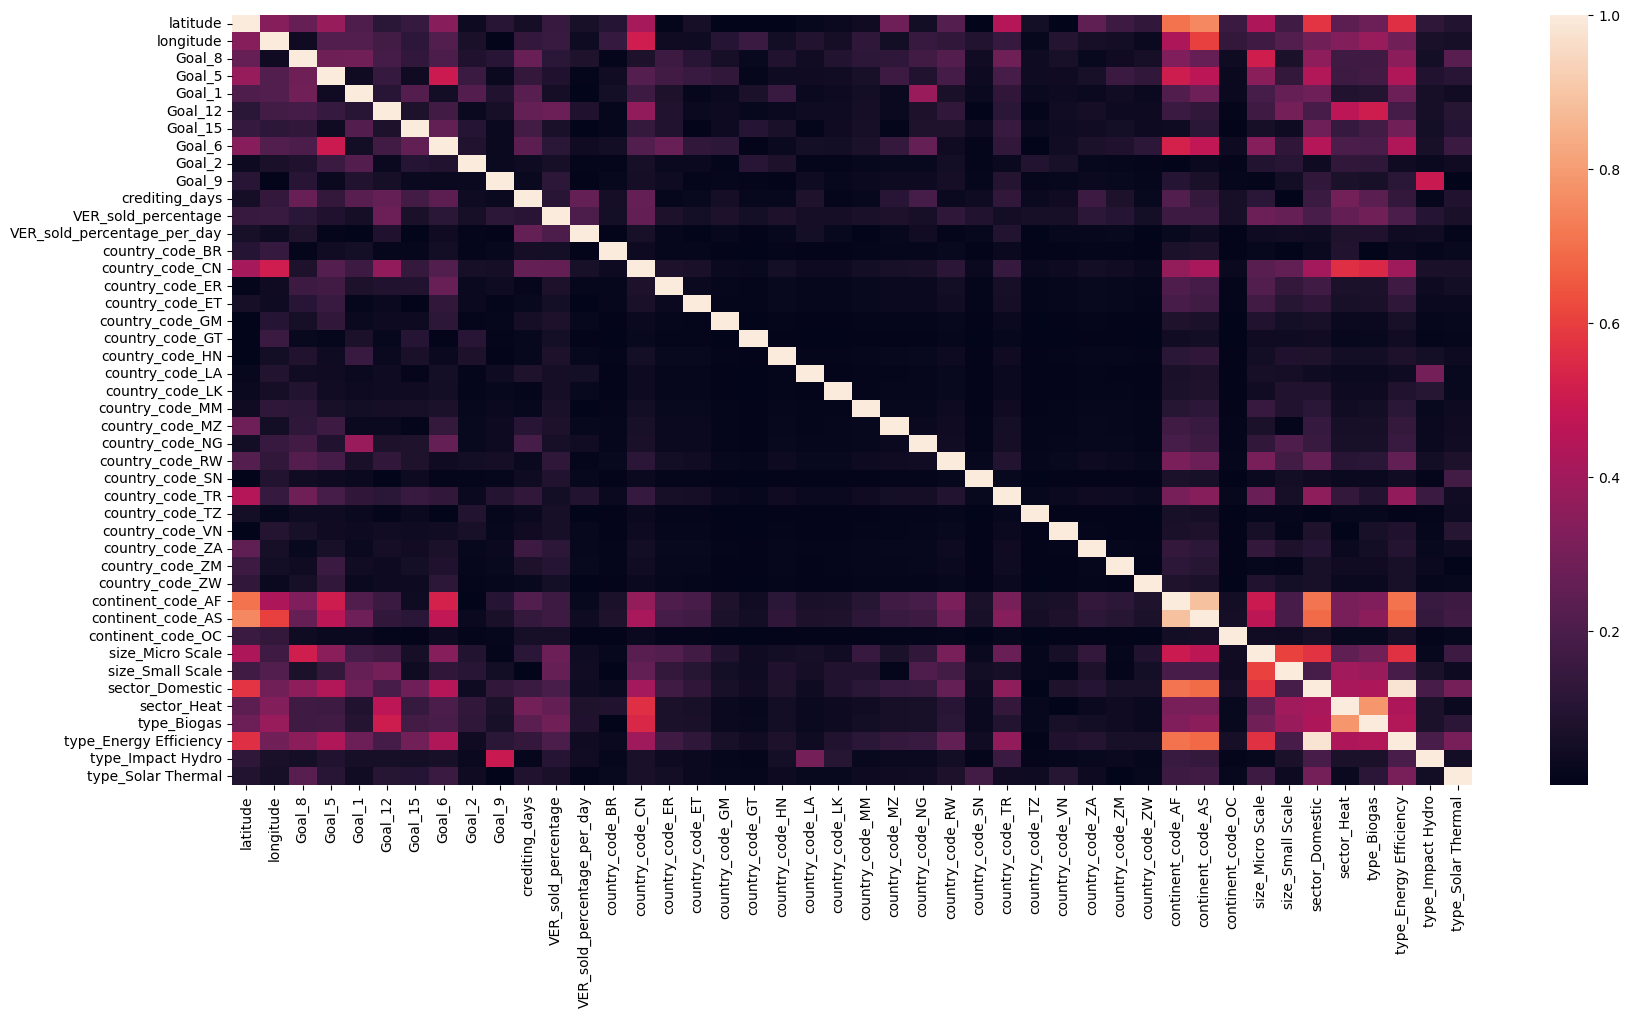

In [18]:
plt.figure(figsize=(20,10))
sns.heatmap(corr_data.corr().abs())

In [19]:
corr_data.corr()[corr_data.corr().abs()>0.5]

,latitude,longitude,Goal_8,Goal_5,Goal_1,Goal_12,Goal_15,Goal_6,Goal_2,Goal_9,...,continent_code_AS,continent_code_OC,size_Micro Scale,size_Small Scale,sector_Domestic,sector_Heat,type_Biogas,type_Energy Efficiency,type_Impact Hydro,type_Solar Thermal
latitude,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.752258,NaN,NaN,NaN,-0.576624,NaN,NaN,-0.565573,NaN,NaN
longitude,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.605227,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Goal_8,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.514547,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Goal_5,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,0.500193,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Goal_1,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Goal_12,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.504575,NaN,NaN,NaN
Goal_15,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Goal_6,NaN,NaN,NaN,0.500193,NaN,NaN,NaN,1.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Goal_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Goal_9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
corr_data.corr()['VER_sold_percentage']

latitude                      -0.147191
longitude                     -0.149945
Goal_8                        -0.109798
Goal_5                         0.084154
Goal_1                        -0.056378
Goal_12                       -0.276667
Goal_15                        0.068186
Goal_6                         0.113046
Goal_2                         0.060847
Goal_9                         0.121072
crediting_days                 0.108833
VER_sold_percentage            1.000000
VER_sold_percentage_per_day    0.202492
country_code_BR                0.052033
country_code_CN               -0.255949
country_code_ER                0.077775
country_code_ET                0.052716
country_code_GM                0.078372
country_code_GT                0.051883
country_code_HN               -0.074873
country_code_LA                0.057835
country_code_LK               -0.058690
country_code_MM                0.070556
country_code_MZ               -0.076167
country_code_NG                0.062930


In [21]:
new_X_train=X_train.drop(['longitude','latitude','continent_code_AF','continent_code_AS','size_Small Scale','sector_Domestic','sector_Heat','Goal_6','Goal_8','Goal_12','country_code_CN','type_Energy Efficiency'],axis=1)
new_X_test=X_test.drop(['longitude','latitude','continent_code_AF','continent_code_AS','size_Small Scale','sector_Domestic','sector_Heat','Goal_6','Goal_8','Goal_12','country_code_CN','type_Energy Efficiency'],axis=1)
new_X=X.drop(['longitude','latitude','continent_code_AF','continent_code_AS','size_Small Scale','sector_Domestic','sector_Heat','Goal_6','Goal_8','Goal_12','country_code_CN','type_Energy Efficiency'],axis=1)

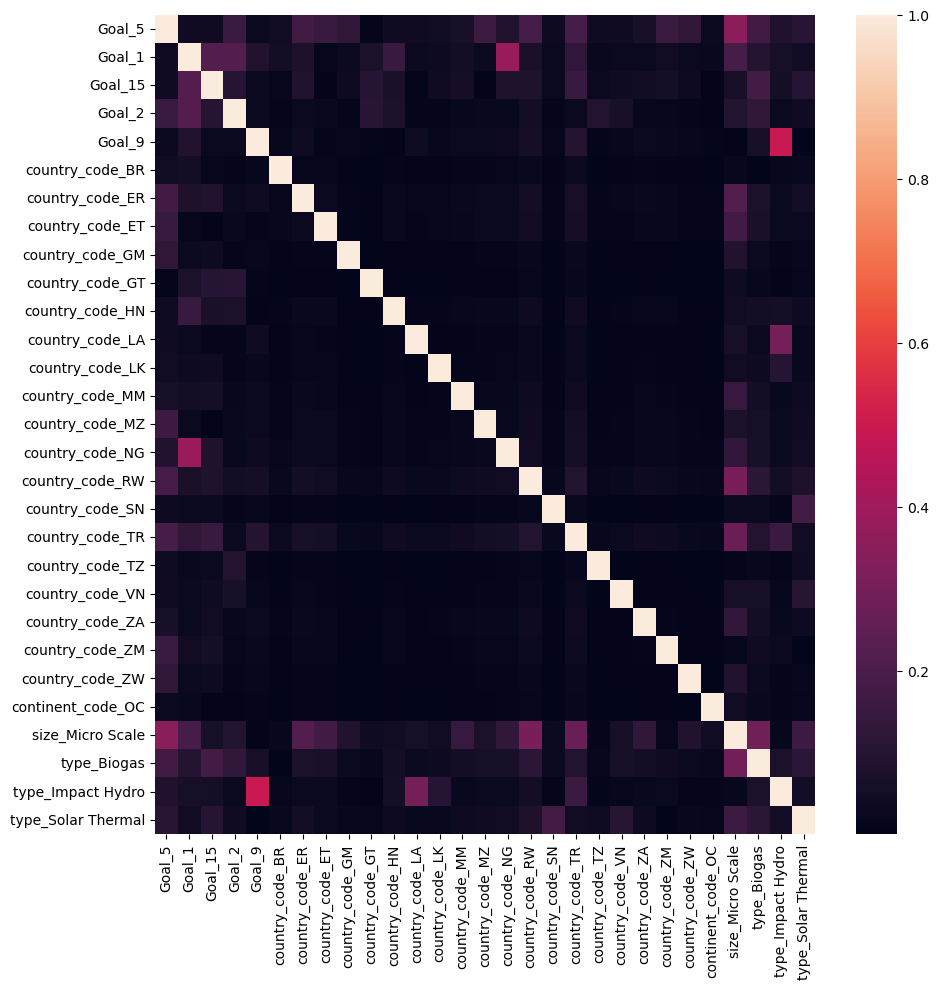

In [22]:
plt.figure(figsize=(10,10))
sns.heatmap(new_X.corr().abs())
plt.tight_layout()

In [23]:
ETR=ExtraTreesRegressor(10,criterion='absolute_error')
SV=SVR()
MLP=MLPRegressor(max_iter=500,activation='logistic')
DT=DecisionTreeRegressor(criterion='absolute_error')
NN=KNeighborsRegressor()
ETRscores=cross_val_score(ETR,new_X_train,y_train,cv=5,scoring=abs_error_scorer,n_jobs=-1)
SVRscores=cross_val_score(SV,new_X_train,y_train,cv=5,scoring=abs_error_scorer,n_jobs=-1)
MLPscores=cross_val_score(MLP,new_X_train,y_train,cv=5,scoring=abs_error_scorer,n_jobs=-1)
DTscores=cross_val_score(DT,new_X_train,y_train,cv=5,scoring=abs_error_scorer,n_jobs=-1)
NNscores=cross_val_score(NN,new_X_train,y_train,cv=5,scoring=abs_error_scorer,n_jobs=-1)
print('Extra Trees Regressor Score:')
score_print(ETRscores)
print('Support Vector Regressor Score:')
score_print(SVRscores)
print('Neural Network Score:')
score_print(MLPscores)
print('Decision Tree Regressor Score:')
score_print(DTscores)
print('Nearest Neighbour Regressor Score:')
score_print(NNscores)

Extra Trees Regressor Score:
0.2581772871709922 +/- 0.008755190436371324
Support Vector Regressor Score:
0.2611275079743416 +/- 0.005934577562415591
Neural Network Score:
0.28700583168802885 +/- 0.00412168851029733
Decision Tree Regressor Score:
0.2580846909577924 +/- 0.008643334184556114
Nearest Neighbour Regressor Score:
0.2845602396803729 +/- 0.011503568814917119


In [24]:
ETR=ExtraTreesRegressor(criterion='absolute_error')
param_grid={'n_estimators':[50,100,150,200,250,300,400],'min_samples_split':[2,5,10,20],'max_features':['auto','sqrt','log2']}
GS=GridSearchCV(estimator=ETR,param_grid=param_grid,cv=5,scoring=abs_error_scorer,n_jobs=-1)
GS_Scores=GS.fit(new_X_train,y_train)

In [25]:
print(GS_Scores.best_score_)
print(GS_Scores.best_params_)
model=GS_Scores.best_estimator_
print(model.score(new_X_test,y_test))

-0.2522112763527899
{'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 250}
-0.1086884965953756
